In [1]:
from models.MNIST_Models import *
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import utils
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool
from art.defences.trainer import AdversarialTrainer
from copy import deepcopy
import os
import matplotlib.pyplot as plt

In [2]:
# Load the data
BATCH_SIZE = 1024
EPS = 0.2

torch.manual_seed(42)
np.random.seed(42)
generator = torch.Generator().manual_seed(42)

# Define the transformation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)

# Split the training dataset into training and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000], generator=generator)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_train, y_train = utils.loader_to_numpy(train_loader)
X_val, y_val = utils.loader_to_numpy(val_loader)
X_test, y_test = utils.loader_to_numpy(test_loader)

In [3]:
# Load each of resnest

original_resnet = MNIST_ResNet()
original_resnet.load_state_dict(torch.load('./models/clean_state/MNIST_ResNet.pth'))
original_resnet.eval()

BIM_resnet = torch.load('./models/hardened_state/BIM_MNIST_ResNet.pth')
BIM_resnet.eval()

FGSM_resnet = torch.load('./models/hardened_state/FGSM_MNIST_ResNet.pth')
FGSM_resnet.eval()

PGD_resnet = torch.load('./models/hardened_state/PGD_MNIST_ResNet.pth')
PGD_resnet.eval()

MNIST_ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [4]:
# Create the ART classifiers
orig_clf = PyTorchClassifier(
    model=original_resnet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(original_resnet.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    device_type='gpu'
)

BIM_clf = PyTorchClassifier(
    model=BIM_resnet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(BIM_resnet.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

FGSM_clf = PyTorchClassifier(
    model=FGSM_resnet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(FGSM_resnet.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

PGD_clf = PyTorchClassifier(
    model=PGD_resnet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(PGD_resnet.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

In [5]:
# Create the ART attacks
FGSM_orig_attack = FastGradientMethod(estimator=orig_clf, eps=EPS, batch_size=BATCH_SIZE)
FGSM_BIM_attack = FastGradientMethod(estimator=BIM_clf, eps=EPS, batch_size=BATCH_SIZE)
FGSM_FGSM_attack = FastGradientMethod(estimator=FGSM_clf, eps=EPS, batch_size=BATCH_SIZE)
FGSM_PGD_attack = FastGradientMethod(estimator=PGD_clf, eps=EPS, batch_size=BATCH_SIZE)

BIM_orig_attack = BasicIterativeMethod(estimator=orig_clf, eps=EPS, batch_size=BATCH_SIZE)
BIM_BIM_attack = BasicIterativeMethod(estimator=BIM_clf, eps=EPS, batch_size=BATCH_SIZE)
BIM_FGSM_attack = BasicIterativeMethod(estimator=FGSM_clf, eps=EPS, batch_size=BATCH_SIZE)
BIM_PGD_attack = BasicIterativeMethod(estimator=PGD_clf, eps=EPS, batch_size=BATCH_SIZE)

PGD_orig_attack = ProjectedGradientDescent(estimator=orig_clf, eps=EPS, batch_size=BATCH_SIZE)
PGD_BIM_attack = ProjectedGradientDescent(estimator=BIM_clf, eps=EPS, batch_size=BATCH_SIZE)
PGD_FGSM_attack = ProjectedGradientDescent(estimator=FGSM_clf, eps=EPS, batch_size=BATCH_SIZE)
PGD_PGD_attack = ProjectedGradientDescent(estimator=PGD_clf, eps=EPS, batch_size=BATCH_SIZE)

In [7]:
# Generate the adversarial examples

X_test_adv_FGSM_orig = FGSM_orig_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_FGSM_BIM = FGSM_BIM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_FGSM_FGSM = FGSM_FGSM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_FGSM_PGD = FGSM_PGD_attack.generate(X_test, batch_size=BATCH_SIZE)

X_test_adv_BIM_orig = BIM_orig_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_BIM_BIM = BIM_BIM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_BIM_FGSM = BIM_FGSM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_BIM_PGD = BIM_PGD_attack.generate(X_test, batch_size=BATCH_SIZE)

X_test_adv_PGD_orig = PGD_orig_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_PGD_BIM = PGD_BIM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_PGD_FGSM = PGD_FGSM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_PGD_PGD = PGD_PGD_attack.generate(X_test, batch_size=BATCH_SIZE)

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
# Evaluate the models on the adversarial examples

FGSM_orig_pred = np.argmax(orig_clf.predict(X_test_adv_FGSM_orig, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of original model on FGSM adversarial examples: ', np.sum(FGSM_orig_pred == y_test) / len(y_test))

FGSM_BIM_pred = np.argmax(BIM_clf.predict(X_test_adv_FGSM_BIM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of BIM hardened model on FGSM adversarial examples: ', np.sum(FGSM_BIM_pred == y_test) / len(y_test))

FGSM_FGSM_pred = np.argmax(FGSM_clf.predict(X_test_adv_FGSM_FGSM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of FGSM hardened model on FGSM adversarial examples: ', np.sum(FGSM_FGSM_pred == y_test) / len(y_test))

FGSM_PGD_pred = np.argmax(PGD_clf.predict(X_test_adv_FGSM_PGD, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of PGD hardened model on FGSM adversarial examples: ', np.sum(FGSM_PGD_pred == y_test) / len(y_test))

BIM_orig_pred = np.argmax(orig_clf.predict(X_test_adv_BIM_orig, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of original model on BIM adversarial examples: ', np.sum(BIM_orig_pred == y_test) / len(y_test))

BIM_BIM_pred = np.argmax(BIM_clf.predict(X_test_adv_BIM_BIM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of BIM hardened model on BIM adversarial examples: ', np.sum(BIM_BIM_pred == y_test) / len(y_test))

BIM_FGSM_pred = np.argmax(FGSM_clf.predict(X_test_adv_BIM_FGSM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of FGSM hardened model on BIM adversarial examples: ', np.sum(BIM_FGSM_pred == y_test) / len(y_test))

BIM_PGD_pred = np.argmax(PGD_clf.predict(X_test_adv_BIM_PGD, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of PGD hardened model on BIM adversarial examples: ', np.sum(BIM_PGD_pred == y_test) / len(y_test))

PGD_orig_pred = np.argmax(orig_clf.predict(X_test_adv_PGD_orig, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of original model on PGD adversarial examples: ', np.sum(PGD_orig_pred == y_test) / len(y_test))

PGD_BIM_pred = np.argmax(BIM_clf.predict(X_test_adv_PGD_BIM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of BIM hardened model on PGD adversarial examples: ', np.sum(PGD_BIM_pred == y_test) / len(y_test))

PGD_FGSM_pred = np.argmax(FGSM_clf.predict(X_test_adv_PGD_FGSM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of FGSM hardened model on PGD adversarial examples: ', np.sum(PGD_FGSM_pred == y_test) / len(y_test))

PGD_PGD_pred = np.argmax(PGD_clf.predict(X_test_adv_PGD_PGD, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of PGD hardened model on PGD adversarial examples: ', np.sum(PGD_PGD_pred == y_test) / len(y_test))

# original model on original images
orig_pred = np.argmax(orig_clf.predict(X_test, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of original model on original images: ', np.sum(orig_pred == y_test) / len(y_test))

Accuracy of original model on FGSM adversarial examples:  0.7599
Accuracy of BIM hardened model on FGSM adversarial examples:  0.9732
Accuracy of FGSM hardened model on FGSM adversarial examples:  0.9771
Accuracy of PGD hardened model on FGSM adversarial examples:  0.9751
Accuracy of original model on BIM adversarial examples:  0.4163
Accuracy of BIM hardened model on BIM adversarial examples:  0.9662
Accuracy of FGSM hardened model on BIM adversarial examples:  0.9675
Accuracy of PGD hardened model on BIM adversarial examples:  0.9712
Accuracy of original model on PGD adversarial examples:  0.4163
Accuracy of BIM hardened model on PGD adversarial examples:  0.9662
Accuracy of FGSM hardened model on PGD adversarial examples:  0.9675
Accuracy of PGD hardened model on PGD adversarial examples:  0.9712
Accuracy of original model on original images:  0.9934


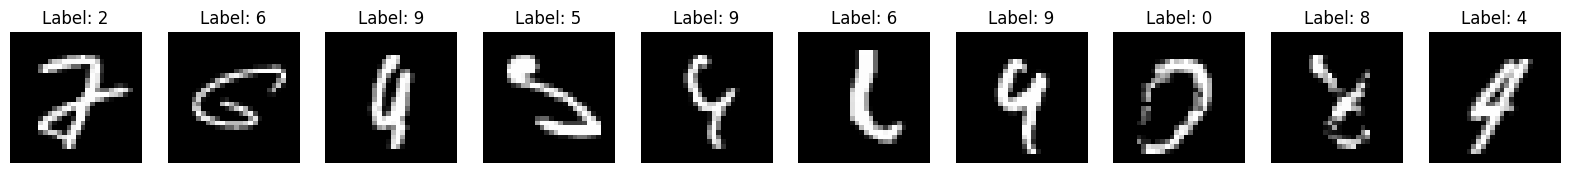

In [10]:
# Find show the original images that were misclassified by the hardened models by classifying the original images

orig_pred = np.argmax(orig_clf.predict(X_test, batch_size=BATCH_SIZE), axis=1)
BIM_pred = np.argmax(BIM_clf.predict(X_test, batch_size=BATCH_SIZE), axis=1)
FGSM_pred = np.argmax(FGSM_clf.predict(X_test, batch_size=BATCH_SIZE), axis=1)
PGD_pred = np.argmax(PGD_clf.predict(X_test, batch_size=BATCH_SIZE), axis=1)

misclassified_indices = np.where((orig_pred != y_test) & (BIM_pred != y_test) & (FGSM_pred != y_test) & (PGD_pred != y_test))[0]

misclassified_images = X_test[misclassified_indices]
misclassified_labels = y_test[misclassified_indices]

fig, ax = plt.subplots(1, 10, figsize=(20, 20))

for i in range(10):
    ax[i].imshow(misclassified_images[i].reshape(28, 28), cmap='gray')
    ax[i].set_title(f'Label: {misclassified_labels[i]}')
    ax[i].axis('off')

In [17]:
# Load each of GoogLeNet

original_googlenet = MNIST_GoogLeNet()
original_googlenet.load_state_dict(torch.load('./models/clean_state/MNIST_GoogLeNet.pth'))
original_googlenet.eval()

BIM_googlenet = torch.load('./models/hardened_state/BIM_MNIST_GoogLeNet.pth')
BIM_googlenet.eval()

FGSM_googlenet = torch.load('./models/hardened_state/FGSM_MNIST_GoogLeNet.pth')
FGSM_googlenet.eval()

PGD_googlenet = torch.load('./models/hardened_state/PGD_MNIST_GoogLeNet.pth')
PGD_googlenet.eval()

MNIST_GoogLeNet(
  (googlenet): GoogLeNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (branch2): Sequential(

In [18]:
# Create the ART classifiers
orig_clf = PyTorchClassifier(
    model=original_googlenet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(original_resnet.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    device_type='gpu'
)

BIM_clf = PyTorchClassifier(
    model=BIM_googlenet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(BIM_resnet.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

FGSM_clf = PyTorchClassifier(
    model=FGSM_googlenet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(FGSM_resnet.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

PGD_clf = PyTorchClassifier(
    model=PGD_googlenet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(PGD_resnet.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

In [19]:
# Create the ART attacks
FGSM_orig_attack = FastGradientMethod(estimator=orig_clf, eps=EPS, batch_size=BATCH_SIZE)
FGSM_BIM_attack = FastGradientMethod(estimator=BIM_clf, eps=EPS, batch_size=BATCH_SIZE)
FGSM_FGSM_attack = FastGradientMethod(estimator=FGSM_clf, eps=EPS, batch_size=BATCH_SIZE)
FGSM_PGD_attack = FastGradientMethod(estimator=PGD_clf, eps=EPS, batch_size=BATCH_SIZE)

BIM_orig_attack = BasicIterativeMethod(estimator=orig_clf, eps=EPS, batch_size=BATCH_SIZE)
BIM_BIM_attack = BasicIterativeMethod(estimator=BIM_clf, eps=EPS, batch_size=BATCH_SIZE)
BIM_FGSM_attack = BasicIterativeMethod(estimator=FGSM_clf, eps=EPS, batch_size=BATCH_SIZE)
BIM_PGD_attack = BasicIterativeMethod(estimator=PGD_clf, eps=EPS, batch_size=BATCH_SIZE)

PGD_orig_attack = ProjectedGradientDescent(estimator=orig_clf, eps=EPS, batch_size=BATCH_SIZE)
PGD_BIM_attack = ProjectedGradientDescent(estimator=BIM_clf, eps=EPS, batch_size=BATCH_SIZE)
PGD_FGSM_attack = ProjectedGradientDescent(estimator=FGSM_clf, eps=EPS, batch_size=BATCH_SIZE)
PGD_PGD_attack = ProjectedGradientDescent(estimator=PGD_clf, eps=EPS, batch_size=BATCH_SIZE)

In [20]:
# Generate the adversarial examples

X_test_adv_FGSM_orig = FGSM_orig_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_FGSM_BIM = FGSM_BIM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_FGSM_FGSM = FGSM_FGSM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_FGSM_PGD = FGSM_PGD_attack.generate(X_test, batch_size=BATCH_SIZE)

X_test_adv_BIM_orig = BIM_orig_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_BIM_BIM = BIM_BIM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_BIM_FGSM = BIM_FGSM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_BIM_PGD = BIM_PGD_attack.generate(X_test, batch_size=BATCH_SIZE)

X_test_adv_PGD_orig = PGD_orig_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_PGD_BIM = PGD_BIM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_PGD_FGSM = PGD_FGSM_attack.generate(X_test, batch_size=BATCH_SIZE)
X_test_adv_PGD_PGD = PGD_PGD_attack.generate(X_test, batch_size=BATCH_SIZE)

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
# Evaluate the models on the adversarial examples

FGSM_orig_pred = np.argmax(orig_clf.predict(X_test_adv_FGSM_orig, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of original model on FGSM adversarial examples: ', np.sum(FGSM_orig_pred == y_test) / len(y_test))

FGSM_BIM_pred = np.argmax(BIM_clf.predict(X_test_adv_FGSM_BIM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of BIM hardened model on FGSM adversarial examples: ', np.sum(FGSM_BIM_pred == y_test) / len(y_test))

FGSM_FGSM_pred = np.argmax(FGSM_clf.predict(X_test_adv_FGSM_FGSM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of FGSM hardened model on FGSM adversarial examples: ', np.sum(FGSM_FGSM_pred == y_test) / len(y_test))

FGSM_PGD_pred = np.argmax(PGD_clf.predict(X_test_adv_FGSM_PGD, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of PGD hardened model on FGSM adversarial examples: ', np.sum(FGSM_PGD_pred == y_test) / len(y_test))

BIM_orig_pred = np.argmax(orig_clf.predict(X_test_adv_BIM_orig, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of original model on BIM adversarial examples: ', np.sum(BIM_orig_pred == y_test) / len(y_test))

BIM_BIM_pred = np.argmax(BIM_clf.predict(X_test_adv_BIM_BIM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of BIM hardened model on BIM adversarial examples: ', np.sum(BIM_BIM_pred == y_test) / len(y_test))

BIM_FGSM_pred = np.argmax(FGSM_clf.predict(X_test_adv_BIM_FGSM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of FGSM hardened model on BIM adversarial examples: ', np.sum(BIM_FGSM_pred == y_test) / len(y_test))

BIM_PGD_pred = np.argmax(PGD_clf.predict(X_test_adv_BIM_PGD, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of PGD hardened model on BIM adversarial examples: ', np.sum(BIM_PGD_pred == y_test) / len(y_test))

PGD_orig_pred = np.argmax(orig_clf.predict(X_test_adv_PGD_orig, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of original model on PGD adversarial examples: ', np.sum(PGD_orig_pred == y_test) / len(y_test))

PGD_BIM_pred = np.argmax(BIM_clf.predict(X_test_adv_PGD_BIM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of BIM hardened model on PGD adversarial examples: ', np.sum(PGD_BIM_pred == y_test) / len(y_test))

PGD_FGSM_pred = np.argmax(FGSM_clf.predict(X_test_adv_PGD_FGSM, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of FGSM hardened model on PGD adversarial examples: ', np.sum(PGD_FGSM_pred == y_test) / len(y_test))

PGD_PGD_pred = np.argmax(PGD_clf.predict(X_test_adv_PGD_PGD, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of PGD hardened model on PGD adversarial examples: ', np.sum(PGD_PGD_pred == y_test) / len(y_test))

# original model on original images
orig_pred = np.argmax(orig_clf.predict(X_test, batch_size=BATCH_SIZE), axis=1)
print('Accuracy of original model on original images: ', np.sum(orig_pred == y_test) / len(y_test))

Accuracy of original model on FGSM adversarial examples:  0.7823
Accuracy of BIM hardened model on FGSM adversarial examples:  0.9707
Accuracy of FGSM hardened model on FGSM adversarial examples:  0.9683
Accuracy of PGD hardened model on FGSM adversarial examples:  0.9665
Accuracy of original model on BIM adversarial examples:  0.3659
Accuracy of BIM hardened model on BIM adversarial examples:  0.9597
Accuracy of FGSM hardened model on BIM adversarial examples:  0.9474
Accuracy of PGD hardened model on BIM adversarial examples:  0.9561
Accuracy of original model on PGD adversarial examples:  0.3659
Accuracy of BIM hardened model on PGD adversarial examples:  0.9597
Accuracy of FGSM hardened model on PGD adversarial examples:  0.9474
Accuracy of PGD hardened model on PGD adversarial examples:  0.9561
Accuracy of original model on original images:  0.994
